In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from glob import glob
import os
import sys
import json
from typing import Dict, List
import numpy as np
import matplotlib.pyplot as plt

sys.path.append(os.path.join(os.getcwd(), "..", "tools"))

In [3]:
from preprocessing.create_a9_temporal_split import TemporalSequenceDetails, create_sequence_details

In [4]:
CLASSES = [
    "CAR",
    "TRUCK",
    "TRAILER",
    "BUS",
    "VAN",
    "BICYCLE",
    "MOTORCYCLE",
    "PEDESTRIAN",
    "EMERGENCY_VEHICLE",
    "OTHER",
]

CLASS_COLORS = {
    "CAR": [0, 0.8, 0.964705882],
    "TRUCK": [0.337254902, 1, 0.71372549],
    "TRAILER": [0.352941176, 1, 0.494117647],
    "VAN": [0.921568627, 0.811764706, 0.211764706],
    "MOTORCYCLE": [0.725490196, 0.643137255, 0.329411765],
    "BUS": [0.850980392, 0.541176471, 0.525490196],
    "PEDESTRIAN": [0.91372549, 0.462745098, 0.976470588],
    "BICYCLE": [0.694117647, 0.549019608, 1],
    "EMERGENCY_VEHICLE": [0.4, 0.419607843, 0.980392157],
    "OTHER": [0.780392157, 0.780392157, 0.780392157],
}

root_path = "../data/a9_temporal_no_split"

In [5]:
def analyze(root_path: str, point_cloud_range = []) -> Dict[str, List[int]]:
    img_label_s1_folder = os.path.join(root_path, "labels_point_clouds", "s110_lidar_ouster_south")
    img_label_s1_paths = sorted(glob(os.path.join(img_label_s1_folder, "*")))
    class_distances = {cls: [] for cls in CLASSES}
    for x in img_label_s1_paths:
        img_label_s1_json_path = os.path.join(x)
        json_data = None
        with open(img_label_s1_json_path, "r") as f:
            json_data = json.load(f)
            frame_idx = list(json_data["openlabel"]["frames"].keys())[0]
            frame_objects = json_data["openlabel"]["frames"][frame_idx]["objects"]

            for obj in frame_objects.values():
                obj_type = obj["object_data"]["type"]
                if "cuboid" in obj["object_data"]:
                    loc = np.asarray(obj["object_data"]["cuboid"]["val"][:3], dtype=np.float32)

                    if len(point_cloud_range) != 0 and not (
                        loc[0] > point_cloud_range[0]
                        and loc[0] < point_cloud_range[3]
                        and loc[1] > point_cloud_range[1]
                        and loc[1] < point_cloud_range[4]
                        and loc[2] > point_cloud_range[2]
                        and loc[2] < point_cloud_range[5]
                    ):
                        continue

                    distance = np.sqrt(np.sum(np.array(loc[:2]) ** 2))
                    class_distances[obj_type].append(distance)

    return class_distances

In [6]:
def plot_class_distances(class_distances: Dict[str, List[int]], title: str = ""):
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.set_title(title)
    ax.set_xlabel("Distance [m]")
    ax.set_ylabel("Frequency")
    for cls, distances in class_distances.items():
        ax.hist(distances, bins=50, label=cls, alpha=0.5, color=CLASS_COLORS[cls])
    ax.legend()
    plt.show()


def plot_class_histograms(class_distances: Dict[str, List[int]]):
    fig, axs = plt.subplots(5, 2, figsize=(10, 25))
    axs = axs.flatten()
    for i, (cls, distances) in enumerate(class_distances.items()):
        axs[i].hist(
            distances, bins=50, range=[0, 160], label=cls, alpha=0.5, color=CLASS_COLORS[cls]
        )
        axs[i].set_title(cls)
    plt.show()


def print_distance_stats(class_distances: Dict[str, List[int]]):
    for cls, distances in class_distances.items():
        print(
            f" {cls:<20} count: {len(distances):<10} min: {np.min(distances):<10.3f} mean: {np.mean(distances):<10.3f} max: {np.max(distances):<10.3f} std: {np.std(distances):<10.2f}"
        )
    print("=" * 100)
    print(
        f" {'Total':<20} count: {np.sum([len(x) for x in class_distances.values()]):<10} min: {np.min([np.min(x) for x in class_distances.values()]):<10.3f} mean: {np.mean([np.mean(x) for x in class_distances.values()]):<10.3f} max: {np.max([np.max(x) for x in class_distances.values()]):<10.3f} std: {np.std([np.std(x) for x in class_distances.values()]):<10.2f}"
    )

# No filtering

In [7]:
class_distances = analyze(root_path)

In [8]:
print_distance_stats(class_distances)

 CAR                  count: 22781      min: 5.595      mean: 42.301     max: 150.753    std: 14.59     
 TRUCK                count: 2704       min: 7.915      mean: 41.355     max: 108.419    std: 13.49     
 TRAILER              count: 3177       min: 7.093      mean: 49.300     max: 147.900    std: 20.36     
 BUS                  count: 908        min: 10.070     mean: 40.666     max: 132.548    std: 18.01     
 VAN                  count: 4553       min: 5.883      mean: 55.168     max: 123.200    std: 20.89     
 BICYCLE              count: 663        min: 18.514     mean: 39.245     max: 60.805     std: 8.15      
 MOTORCYCLE           count: 734        min: 16.459     mean: 37.207     max: 46.332     std: 5.64      
 PEDESTRIAN           count: 2507       min: 19.270     mean: 40.579     max: 68.811     std: 5.77      
 EMERGENCY_VEHICLE    count: 142        min: 6.321      mean: 58.965     max: 74.833     std: 20.92     
 OTHER                count: 84         min: 5.715     

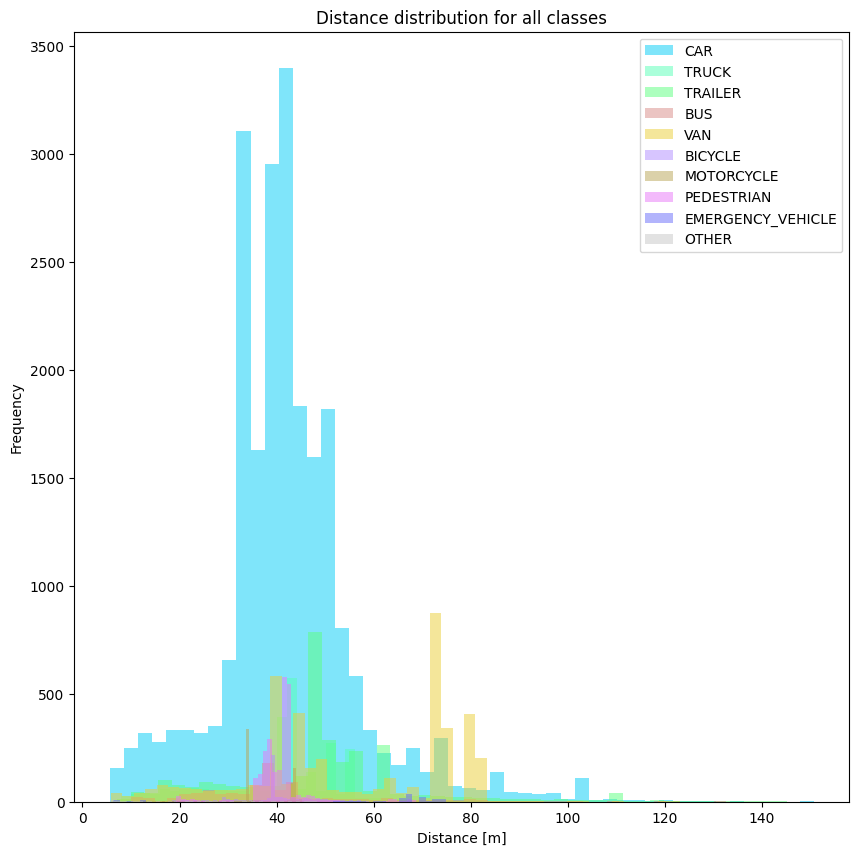

In [9]:
plot_class_distances(class_distances, "Distance distribution for all classes")

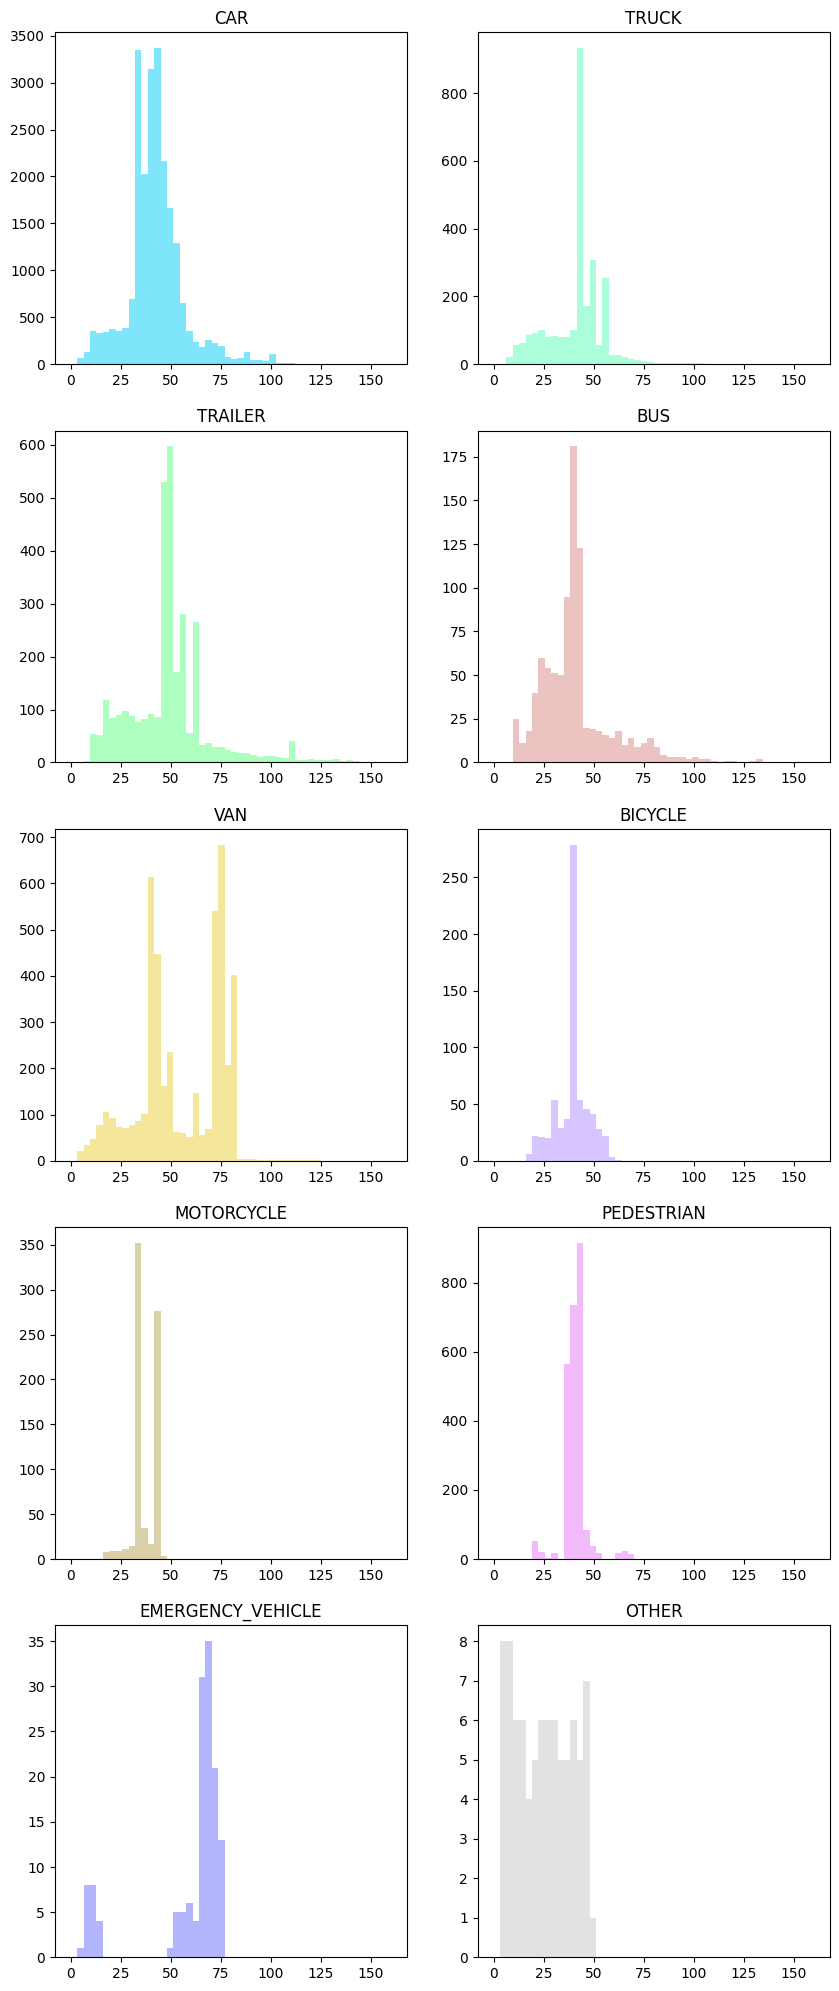

In [10]:
plot_class_histograms(class_distances)

# With Filtering

In [11]:
point_cloud_range = [-25.0, -75.0, -10.0, 125.0, 75.0, 0.0]
class_distances = analyze(root_path, point_cloud_range)

In [12]:
print_distance_stats(class_distances)

 CAR                  count: 21436      min: 5.595      mean: 40.921     max: 119.697    std: 12.53     
 TRUCK                count: 2626       min: 7.915      mean: 41.078     max: 108.419    std: 13.41     
 TRAILER              count: 2953       min: 7.093      mean: 46.239     max: 120.242    std: 15.59     
 BUS                  count: 898        min: 10.070     mean: 40.045     max: 119.497    std: 16.95     
 VAN                  count: 4477       min: 5.883      mean: 55.321     max: 123.200    std: 20.95     
 BICYCLE              count: 663        min: 18.514     mean: 39.245     max: 60.805     std: 8.15      
 MOTORCYCLE           count: 734        min: 16.459     mean: 37.207     max: 46.332     std: 5.64      
 PEDESTRIAN           count: 2507       min: 19.270     mean: 40.579     max: 68.811     std: 5.77      
 EMERGENCY_VEHICLE    count: 142        min: 6.321      mean: 58.965     max: 74.833     std: 20.92     
 OTHER                count: 84         min: 5.715     

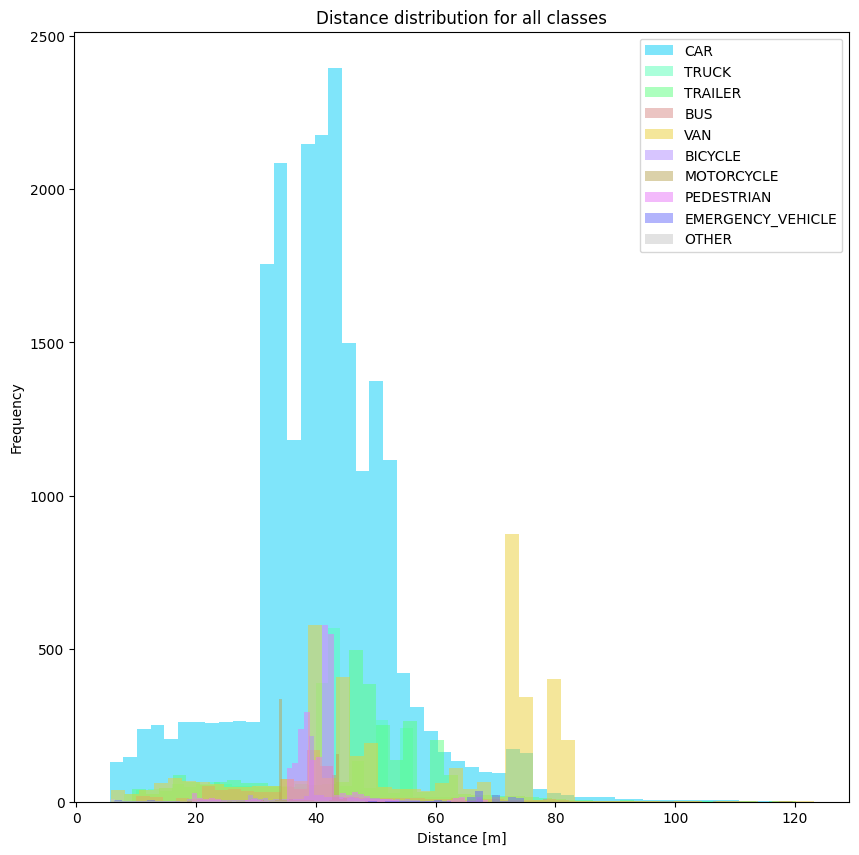

In [13]:
plot_class_distances(class_distances, "Distance distribution for all classes")

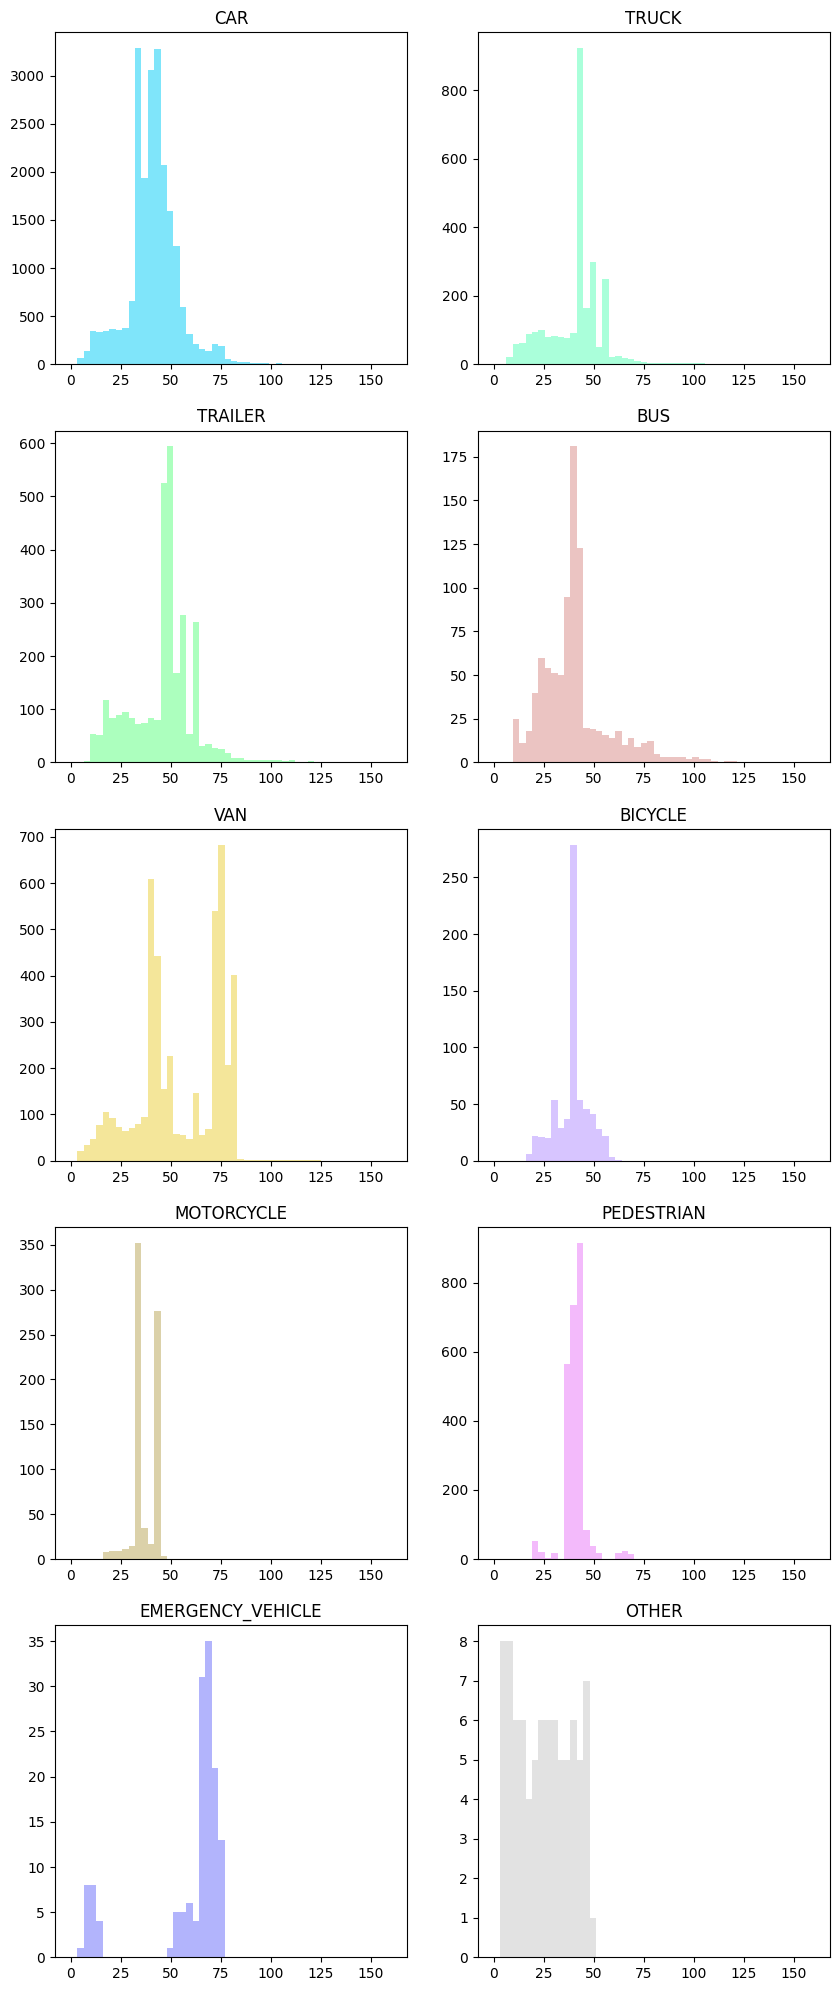

In [14]:
plot_class_histograms(class_distances)